Here we implement Logistic Regression using the Pyro library.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

sns.set_context("notebook")
try:
    import pyro
except ImportError:
    %pip install pyro-ppl
    import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive

In [ ]:
X, y = make_moons(n_samples=100, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()
X_train.shape, y_train.shape,X_test.shape, y_test.shape

(torch.Size([80, 2]), torch.Size([80]), torch.Size([20, 2]), torch.Size([20]))

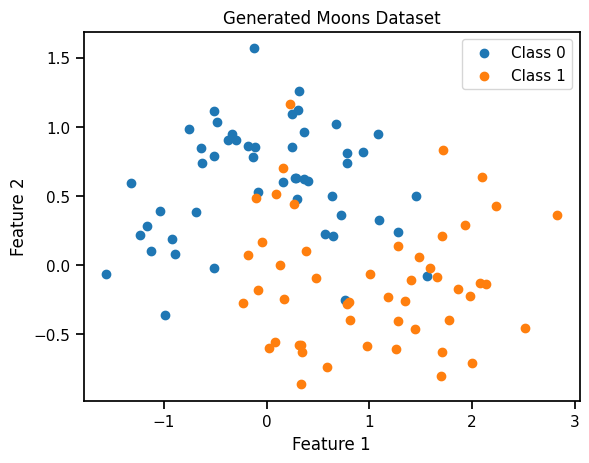

In [ ]:
# Separate data points by class
class_0 = X[y == 0]
class_1 = X[y == 1]

# Create a scatter plot
plt.scatter(class_0[:, 0], class_0[:, 1], label="Class 0", marker='o')
plt.scatter(class_1[:, 0], class_1[:, 1], label="Class 1", marker='o')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Moons Dataset")
plt.legend()
plt.show()

In [ ]:
def logistic_model(X, y):
    # sample from prior
    w = pyro.sample(
      'w', dist.Normal(torch.zeros(X.shape[1]), torch.ones(X.shape[1]))
    )
    b = pyro.sample(
      'b', dist.Normal(torch.zeros(1), torch.ones(1))
    )
    with pyro.iarange('data', X.shape[0]):
        model_logits = torch.matmul(X, w) + b
        pyro.sample('obs', dist.Bernoulli(logits=model_logits), obs=y)

We use NUTS MCMC sampling to sample the posterior and take 1000 samples for posterior distribution and use 500 samples as burn/warm up.

In [ ]:
nuts_kernel = NUTS(logistic_model, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500)
mcmc.run(X_train, y_train)

Warmup:   0%|          | 3/1500 [00:00, 25.77it/s, step size=1.20e-01, acc. prob=0.333]

Sample: 100%|██████████| 1500/1500 [00:32, 46.05it/s, step size=6.50e-01, acc. prob=0.929] 


In [ ]:
posterior_samples = mcmc.get_samples()

Following are the trace plots for the parameters of the posterior distribution.

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


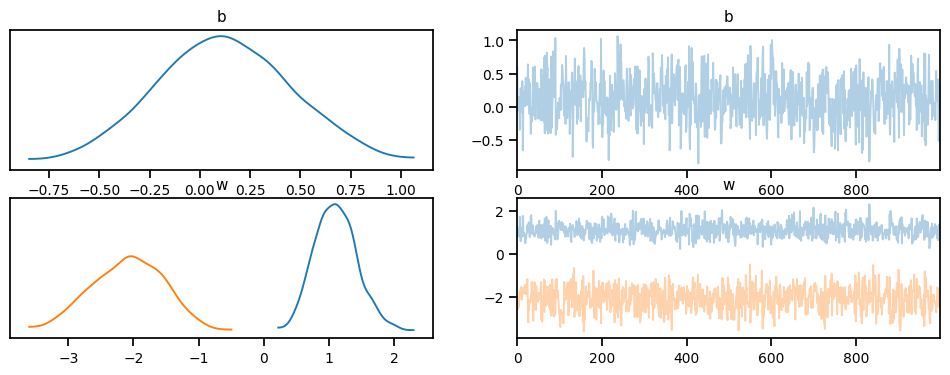

In [ ]:
import arviz as az

idata = az.from_pyro(mcmc)
az.plot_trace(idata, compact=True);

In [ ]:
posterior_samples['w'].mean(0), posterior_samples['b'].mean(0)

(tensor([ 1.1069, -2.0874]), tensor([0.1179]))

In [ ]:
posterior_samples['w'].std(0), posterior_samples['b'].std(0)

(tensor([0.3259, 0.5515]), tensor([0.3369]))

Ploting the decision boundry for the test data

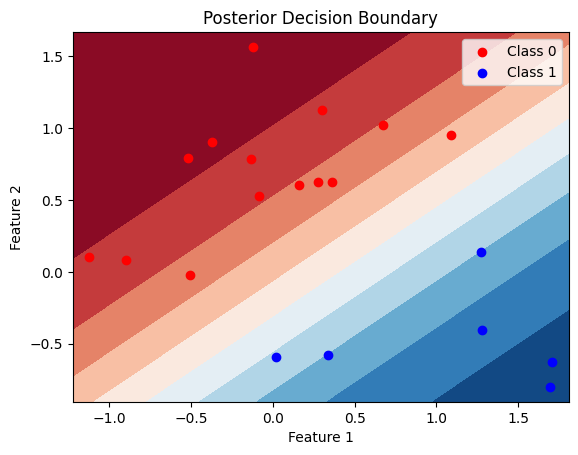

In [ ]:
# Define a function to plot the decision boundary
def plot_decision_boundary(X, y, posterior_samples, title="Posterior Decision Boundary"):
    # Create a meshgrid of points for the entire feature space
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100), torch.linspace(y_min, y_max, 100))

    # Flatten the meshgrid for prediction
    grid = torch.cat((xx.reshape(-1, 1), yy.reshape(-1, 1)), dim=1)

    # Get the number of posterior samples
    num_samples = len(posterior_samples['w'])

    # Plot the posterior decision boundary for each sample
    for i in range(num_samples):
        w = posterior_samples['w'][i]
        b = posterior_samples['b'][i]

        # Calculate the logits and probabilities
        logits = torch.matmul(grid, w) + b
        probs = 1 / (1 + torch.exp(-logits))
        probs = probs.detach().numpy().reshape(xx.shape)

        # Plot the decision boundary
        # plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, cmap=plt.cm.RdBu)
        plt.contourf(xx, yy, probs, 10, cmap=plt.cm.RdBu)
    # Plot the data points
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label="Class 0", marker='o', color = 'r')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label="Class 1", marker='o', color = 'b')

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.legend()
    plt.show()

# Plot the decision boundary on the test data
plot_decision_boundary(X_test, y_test, posterior_samples)